In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import copy
import pickle

import scipy
import numpy as np

from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.stats import sigma_clipped_stats, sigma_clip

import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
def sweep_flux_to_mag(catalog, band):
    """Convert flux into magnitude for DECaLS Sweep catalog."""
    flux_dered = catalog['FLUX_' + band.strip()] / catalog['MW_TRANSMISSION_' + band.strip()]
    return -2.5 * np.log10(flux_dered) + 22.5

def sweep_mag_err(catalog, band):
    """Estimate error of magnitude in certain band."""
    sn_ratio = catalog['FLUX_' + band.strip()] * np.sqrt(catalog['FLUX_IVAR_' + band.strip()])
    return 2.5 * np.log10(1. + 1. / sn_ratio)
    

def select_point_sources(sweep_file):
    """Select point sources from a SWEEP catalog."""
    print("\n# Dealing with catalog: {:s}".format(sweep_file))
    
    sweep = Table.read(sweep_file)
    print("# There are {:d} objects in the catalog".format(len(sweep)))
    
    psf_mask = sweep['TYPE'] == u'PSF '
    dup_mask = sweep['TYPE'] == u'DUP '
    print("# There are {:d} PSF objects".format(psf_mask.sum()))
    print("# There are {:d} DUP objects".format(dup_mask.sum()))
    
    psrc = copy.deepcopy(sweep[psf_mask | dup_mask])
    
    # Flag for point sources with detections in all GRZ bands
    use_mask = ((psrc['FLUX_G'] > 0) & (psrc['FLUX_R'] > 0) & (psrc['FLUX_Z'] > 0))
    print("# There are {:d} objects with useful flux in GRZ bands".format(use_mask.sum()))
    psrc.add_column(Column(data=use_mask, name='GRZ_DETECT'))
    
    # Flag for point sources with S/N > 5 detections in all GRZ bands
    good_mask = ((psrc['FLUX_G'] * np.sqrt(psrc['FLUX_IVAR_G']) > 5.) & 
                 (psrc['FLUX_R'] * np.sqrt(psrc['FLUX_IVAR_R']) > 5.) & 
                 (psrc['FLUX_Z'] * np.sqrt(psrc['FLUX_IVAR_Z']) > 5.))
    print("# There are {:d} objects with S/N>5 detections in GRZ bands".format(good_mask.sum()))
    psrc.add_column(Column(data=good_mask, name='GRZ_GOOD'))
    
    # Convert flux into magnitude after MW extinction correction
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'G'), name='MAG_G_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'R'), name='MAG_R_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'Z'), name='MAG_Z_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'W1'), name='MAG_W1_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'W2'), name='MAG_W2_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'W3'), name='MAG_W3_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'W4'), name='MAG_W4_DERED'))
    
    # Convert flux invar into magnitude error
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'G'), name='MAG_G_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'R'), name='MAG_R_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'Z'), name='MAG_Z_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'W1'), name='MAG_W1_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'W2'), name='MAG_W2_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'W3'), name='MAG_W3_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'W4'), name='MAG_W4_ERR'))
    
    psrc_file = sweep_file.replace('.fits', '_psrc.fits')
    psrc.write(psrc_file, overwrite=True)
    
    return psrc

## 2020-09-09

In [2]:
fits_dir = '/Users/song/Downloads/for_jenny/'

sweep_list = glob.glob(fits_dir + '*.fits')

In [11]:
psrc_comb = vstack([select_point_sources(cat) for cat in sweep_list])


# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-330p000-340p005.fits
# There are 4724391 objects in the catalog
# There are 2202086 PSF objects
# There are 210 DUP objects
# There are 2104487 objects with useful flux in GRZ bands
# There are 876758 objects with S/N>5 detections in GRZ bands


<ipython-input-10-e1bea5bdb1c9>:4: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux_dered) + 22.5
<ipython-input-10-e1bea5bdb1c9>:4: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux_dered) + 22.5
<ipython-input-10-e1bea5bdb1c9>:9: RuntimeWarning: divide by zero encountered in true_divide
  return 2.5 * np.log10(1. + 1. / sn_ratio)
<ipython-input-10-e1bea5bdb1c9>:9: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10(1. + 1. / sn_ratio)



# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-330p005-340p010.fits
# There are 3939753 objects in the catalog
# There are 1896792 PSF objects
# There are 93 DUP objects
# There are 1808538 objects with useful flux in GRZ bands
# There are 844202 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-320m005-330p000.fits
# There are 5205828 objects in the catalog
# There are 2660478 PSF objects
# There are 195 DUP objects
# There are 2533130 objects with useful flux in GRZ bands
# There are 1200762 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-320p000-330p005.fits
# There are 5287534 objects in the catalog
# There are 2772375 PSF objects
# There are 212 DUP objects
# There are 2639762 objects with useful flux in GRZ bands
# There are 1285281 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-320p005-330p010

<ipython-input-10-e1bea5bdb1c9>:9: RuntimeWarning: divide by zero encountered in log10
  return 2.5 * np.log10(1. + 1. / sn_ratio)



# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-330m005-340p000.fits
# There are 4738984 objects in the catalog
# There are 2118507 PSF objects
# There are 281 DUP objects
# There are 2021420 objects with useful flux in GRZ bands
# There are 828951 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-330p010-340p015.fits
# There are 3916635 objects in the catalog
# There are 2023925 PSF objects
# There are 221 DUP objects
# There are 1933643 objects with useful flux in GRZ bands
# There are 909853 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-320p010-330p015.fits
# There are 4600477 objects in the catalog
# There are 2678463 PSF objects
# There are 210 DUP objects
# There are 2548841 objects with useful flux in GRZ bands
# There are 1398154 objects with S/N>5 detections in GRZ bands


In [12]:
print(len(psrc_comb), psrc_comb['GRZ_DETECT'].sum(), psrc_comb['GRZ_GOOD'].sum())

18771721 17875797 8533198


Text(0.5, 0, '$\\rm Magnitude$')

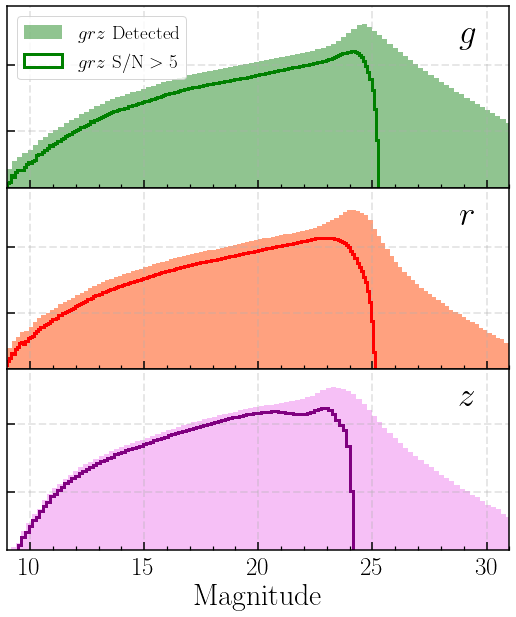

In [13]:
fig = plt.figure(figsize=(9, 10))
plt.subplots_adjust(wspace=0, hspace=0)

ax1 = plt.subplot(311)
ax1.set_yscale('log')
ax1.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax1.hist(psrc_comb['MAG_G_DERED'][psrc_comb['GRZ_DETECT']], bins=200, 
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='forestgreen')
_ = ax1.hist(psrc_comb['MAG_G_DERED'][psrc_comb['GRZ_GOOD']], bins=200, 
             density=False, histtype='step', linewidth=3, label=r'$grz\ {\rm S/N} > 5$',
             color='green')
ax1.legend(loc='best', fontsize=19)
ax1.set_xlim(9, 31)
ax1.set_ylim(20, 6e6)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.text(0.9, 0.8, r'$g$', fontsize=35, transform=ax1.transAxes)

ax2 = plt.subplot(312)
ax2.set_yscale('log')
ax2.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax2.hist(psrc_comb['MAG_R_DERED'][psrc_comb['GRZ_DETECT']], bins=200, 
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='orangered')
_ = ax2.hist(psrc_comb['MAG_R_DERED'][psrc_comb['GRZ_GOOD']], bins=200, 
             density=False, histtype='step', linewidth=3, label=r'$grz\ {\rm S/N} > 5$',
             color='red')
ax2.set_ylim(20, 6e6)
ax2.set_xlim(9, 31)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax2.text(0.9, 0.8, r'$r$', fontsize=35, transform=ax2.transAxes)

ax3 = plt.subplot(313)
ax3.set_yscale('log')
ax3.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax3.hist(psrc_comb['MAG_Z_DERED'][psrc_comb['GRZ_DETECT']], bins=200, 
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='violet')
_ = ax3.hist(psrc_comb['MAG_Z_DERED'][psrc_comb['GRZ_GOOD']], bins=200, 
             density=False, histtype='step', linewidth=3, label=r'$grz\ {\rm S/N} > 5$',
             color='purple')
ax3.set_ylim(20, 4e6)
ax3.set_xlim(9, 31)
ax3.yaxis.set_ticklabels([])
ax3.text(0.9, 0.8, r'$z$', fontsize=35, transform=ax3.transAxes)

ax3.set_xlabel(r'$\rm Magnitude$', fontsize=30)

In [21]:
psrc_good = psrc_comb[psrc_comb['GRZ_GOOD'] > 0]

col_use = [
    'BRICKID', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 
    'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 'NOBS_W3', 'NOBS_W4',
    'RCHISQ_G', 'RCHISQ_R', 'RCHISQ_Z', 'RCHISQ_W1', 'RCHISQ_W2', 'RCHISQ_W3', 'RCHISQ_W4',
    'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 'FRACFLUX_W3', 'FRACFLUX_W4',
    'FRACMASKED_G','FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z',
    'ANYMASK_G', 'ANYMASK_R', 'ANYMASK_Z', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z',
    'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z',
    'PSFDEPTH_W1', 'PSFDEPTH_W2',
    'SHAPEEXP_R', 'SHAPEEXP_R_IVAR', 'SHAPEEXP_E1', 'SHAPEEXP_E1_IVAR', 'SHAPEEXP_E2', 'SHAPEEXP_E2_IVAR',
    'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR',
    'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR', 
    'GAIA_PHOT_RP_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR',
    'GAIA_ASTROMETRIC_EXCESS_NOISE', 'GAIA_DUPLICATED_SOURCE', 'GAIA_PHOT_BP_RP_EXCESS_FACTOR',
    'GAIA_ASTROMETRIC_SIGMA5D_MAX', 'GAIA_ASTROMETRIC_PARAMS_SOLVED',
    'PARALLAX', 'PARALLAX_IVAR', 'PMRA', 'PMRA_IVAR', 'PMDEC', 'PMDEC_IVAR',
    'MASKBITS', 
    'MAG_G_DERED', 'MAG_R_DERED', 'MAG_Z_DERED', 'MAG_W1_DERED', 'MAG_W2_DERED', 'MAG_W3_DERED', 'MAG_W4_DERED',
    'MAG_G_ERR', 'MAG_R_ERR', 'MAG_Z_ERR', 'MAG_W1_ERR', 'MAG_W2_ERR', 'MAG_W3_ERR', 'MAG_W4_ERR'
]

psrc_use = psrc_good[col_use]

In [24]:
psrc_fdfc = psrc_use[(psrc_use['NOBS_G'] > 2) & (psrc_use['NOBS_R'] > 2) & (psrc_use['NOBS_Z'] > 2)]

print(len(psrc_fdfc))

6397087


In [28]:
psrc_fdfc.write(os.path.join(fits_dir, 'dr8_320m05_340p15_psrc_good.fits'), overwrite=True)

In [26]:
gr_color = psrc_fdfc['MAG_G_DERED'] - psrc_fdfc['MAG_R_DERED']
rz_color = psrc_fdfc['MAG_R_DERED'] - psrc_fdfc['MAG_Z_DERED']

Text(0, 0.5, '$r-z\\ [\\rm mag]$')

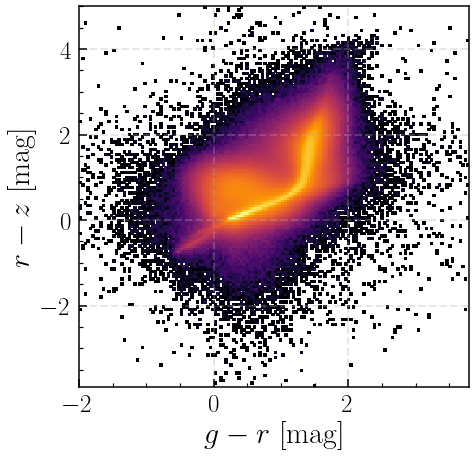

In [32]:
fig = plt.figure(figsize=(7, 7))

ax1 = plt.subplot(111)

# 2-D histogram
ax1.hist2d(
    gr_color, rz_color, bins=[150, 150], cmin=1, cmap='inferno',
    range=([-2, 3.8], [-3.9, 5]), norm=mpl.colors.LogNorm())

ax1.grid(linestyle='--', linewidth=2, alpha=0.3)
ax1.set_xlabel(r'$g-r\ [\rm mag]$', fontsize=30)
ax1.set_ylabel(r'$r-z\ [\rm mag]$', fontsize=30)

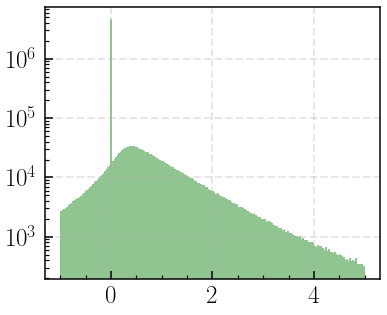

In [54]:
fig = plt.figure(figsize=(6, 5))

ax1 = plt.subplot(111)
ax1.set_yscale('log')
ax1.grid(linestyle='--', linewidth=2, alpha=0.3)

_ = ax1.hist(psrc_fdfc['PARALLAX'], bins=200, range=[-1, 5],
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='forestgreen')

ax1.set_xlabel(r'$\rm $')

Text(0.5, 0, '${\\rm Reduced}\\ \\chi^2$')

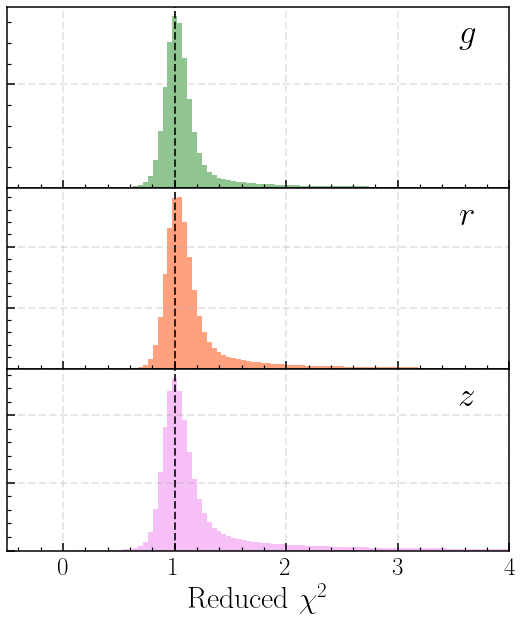

In [49]:
fig = plt.figure(figsize=(9, 10))
plt.subplots_adjust(wspace=0, hspace=0)

ax1 = plt.subplot(311)
ax1.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax1.hist(psrc_fdfc['RCHISQ_G'], bins=250, range=[-1, 10],
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='forestgreen')
ax1.axvline(1.0, linewidth=2, linestyle='--', c='k', alpha=0.8)
#ax1.legend(loc='best', fontsize=19)
ax1.set_xlim(-0.5, 4)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.text(0.9, 0.8, r'$g$', fontsize=35, transform=ax1.transAxes)

ax2 = plt.subplot(312)
ax2.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax2.hist(psrc_fdfc['RCHISQ_R'], bins=250, range=[-1, 10],
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='orangered')
ax2.axvline(1.0, linewidth=2, linestyle='--', c='k', alpha=0.8)
ax2.set_xlim(-0.5, 4)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax2.text(0.9, 0.8, r'$r$', fontsize=35, transform=ax2.transAxes)

ax3 = plt.subplot(313)
ax3.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax3.hist(psrc_fdfc['RCHISQ_Z'], bins=250, range=[-1, 10],
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='violet')
ax3.axvline(1.0, linewidth=2, linestyle='--', c='k', alpha=0.8)
ax3.set_xlim(-0.5, 4)
ax3.yaxis.set_ticklabels([])
ax3.text(0.9, 0.8, r'$z$', fontsize=35, transform=ax3.transAxes)

ax3.set_xlabel(r'${\rm Reduced}\ \chi^2$', fontsize=30)

## 2020-09-22

https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-000p010-010p015.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-000p015-010p020.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-000p020-010p025.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-000p025-010p030.fits

https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-010p010-020p015.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-010p015-020p020.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-010p020-020p025.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-010p025-020p030.fits

https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-020p010-030p015.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-020p015-030p020.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-020p020-030p025.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-020p025-030p030.fits

https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-030p010-040p015.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-030p015-040p020.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-030p020-040p025.fits
https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-030p025-040p030.fits

In [3]:
fits_dir = '/Users/song/astro6/project/for_jenny/0922/'

sweep_list = glob.glob(fits_dir + '*.fits')

In [5]:
psrc_comb = vstack([select_point_sources(cat) for cat in sweep_list])


# Dealing with catalog: /Users/song/astro6/project/for_jenny/0922/sweep-000p010-010p015.fits
# There are 3373859 objects in the catalog
# There are 1403836 PSF objects
# There are 262 DUP objects
# There are 1350488 objects with useful flux in GRZ bands
# There are 491884 objects with S/N>5 detections in GRZ bands


<ipython-input-2-e1bea5bdb1c9>:4: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux_dered) + 22.5
<ipython-input-2-e1bea5bdb1c9>:4: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux_dered) + 22.5
<ipython-input-2-e1bea5bdb1c9>:9: RuntimeWarning: divide by zero encountered in true_divide
  return 2.5 * np.log10(1. + 1. / sn_ratio)
<ipython-input-2-e1bea5bdb1c9>:9: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10(1. + 1. / sn_ratio)



# Dealing with catalog: /Users/song/astro6/project/for_jenny/0922/sweep-000p015-010p020.fits
# There are 3211257 objects in the catalog
# There are 1416917 PSF objects
# There are 298 DUP objects
# There are 1359408 objects with useful flux in GRZ bands
# There are 514571 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/astro6/project/for_jenny/0922/sweep-000p020-010p025.fits
# There are 3198960 objects in the catalog
# There are 1489772 PSF objects
# There are 229 DUP objects
# There are 1431870 objects with useful flux in GRZ bands
# There are 579551 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/astro6/project/for_jenny/0922/sweep-000p025-010p030.fits
# There are 3119185 objects in the catalog
# There are 1545945 PSF objects
# There are 304 DUP objects
# There are 1482434 objects with useful flux in GRZ bands
# There are 622139 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/astro6/proje

In [6]:
len(psrc_comb)

22535191

In [7]:
psrc_good = psrc_comb[psrc_comb['GRZ_GOOD'] > 0]

col_use = [
    'BRICKID', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 
    'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 'NOBS_W3', 'NOBS_W4',
    'RCHISQ_G', 'RCHISQ_R', 'RCHISQ_Z', 'RCHISQ_W1', 'RCHISQ_W2', 'RCHISQ_W3', 'RCHISQ_W4',
    'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 'FRACFLUX_W3', 'FRACFLUX_W4',
    'FRACMASKED_G','FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z',
    'ANYMASK_G', 'ANYMASK_R', 'ANYMASK_Z', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z',
    'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z',
    'PSFDEPTH_W1', 'PSFDEPTH_W2',
    'SHAPEEXP_R', 'SHAPEEXP_R_IVAR', 'SHAPEEXP_E1', 'SHAPEEXP_E1_IVAR', 'SHAPEEXP_E2', 'SHAPEEXP_E2_IVAR',
    'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR',
    'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR', 
    'GAIA_PHOT_RP_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR',
    'GAIA_ASTROMETRIC_EXCESS_NOISE', 'GAIA_DUPLICATED_SOURCE', 'GAIA_PHOT_BP_RP_EXCESS_FACTOR',
    'GAIA_ASTROMETRIC_SIGMA5D_MAX', 'GAIA_ASTROMETRIC_PARAMS_SOLVED',
    'PARALLAX', 'PARALLAX_IVAR', 'PMRA', 'PMRA_IVAR', 'PMDEC', 'PMDEC_IVAR',
    'MASKBITS', 
    'MAG_G_DERED', 'MAG_R_DERED', 'MAG_Z_DERED', 'MAG_W1_DERED', 'MAG_W2_DERED', 'MAG_W3_DERED', 'MAG_W4_DERED',
    'MAG_G_ERR', 'MAG_R_ERR', 'MAG_Z_ERR', 'MAG_W1_ERR', 'MAG_W2_ERR', 'MAG_W3_ERR', 'MAG_W4_ERR'
]

psrc_use = psrc_good[col_use]

psrc_fdfc = psrc_use[
    (psrc_use['NOBS_G'] > 1) & (psrc_use['NOBS_R'] > 1) & (psrc_use['NOBS_Z'] > 1)]

print(len(psrc_fdfc))

6351154


In [37]:
psrc_final = psrc_use[(psrc_use['RA'] >= 9.35) & (psrc_use['RA'] <= 30.65)]

print(len(psrc_final))

4441416


In [38]:
psrc_final.write(os.path.join(fits_dir, 'dr8_9p10_30p30_psrc_good.fits'), overwrite=True)

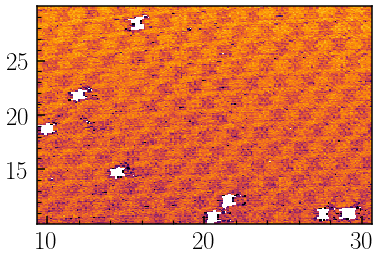

In [29]:
_ = plt.hist2d(psrc_final[mask]['RA'], psrc_final[mask]['DEC'], bins=[200, 200], cmap='inferno',
               norm=mpl.colors.LogNorm())

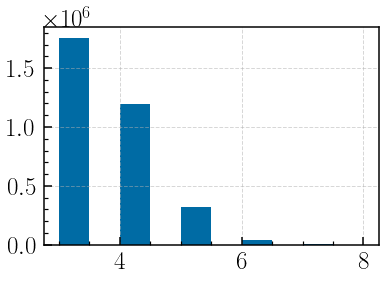

In [30]:
_ = plt.hist(psrc_final['NOBS_R'])

In [32]:
psrc_1 = psrc_final[psrc_final['NOBS_R'] <= 3]
psrc_2 = psrc_final[psrc_final['NOBS_R'] > 3]
print(len(psrc_1), len(psrc_2))

1759544 1568242


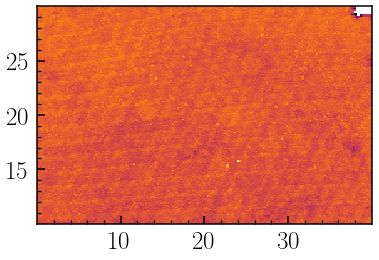

In [36]:
_ = plt.hist2d(psrc_use['RA'], psrc_use['DEC'], bins=[200, 200], cmap='inferno',
               norm=mpl.colors.LogNorm())

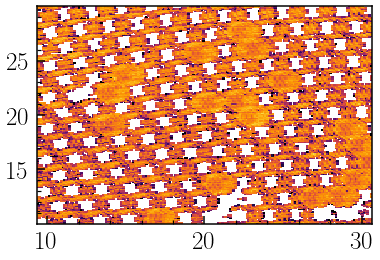

In [34]:
_ = plt.hist2d(psrc_2['RA'], psrc_2['DEC'], bins=[200, 200], cmap='inferno',
               norm=mpl.colors.LogNorm())

Text(0.5, 0, '$\\rm Magnitude$')

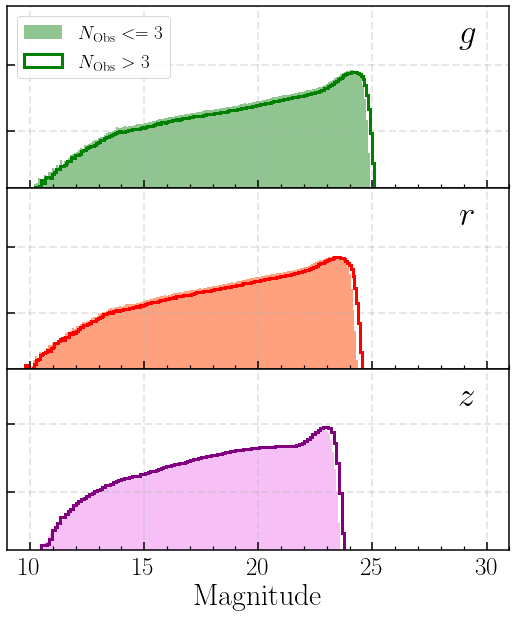

In [35]:
fig = plt.figure(figsize=(9, 10))
plt.subplots_adjust(wspace=0, hspace=0)

ax1 = plt.subplot(311)
ax1.set_yscale('log')
ax1.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax1.hist(psrc_1['MAG_G_DERED'], bins=200, 
             density=False, alpha=0.5, label=r'$N_{\rm Obs} <= 3$', 
             color='forestgreen')
_ = ax1.hist(psrc_2['MAG_G_DERED'], bins=200, 
             density=False, histtype='step', linewidth=3, label=r'$N_{\rm Obs} > 3$',
             color='green')
ax1.legend(loc='best', fontsize=19)
ax1.set_xlim(9, 31)
ax1.set_ylim(20, 6e6)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.text(0.9, 0.8, r'$g$', fontsize=35, transform=ax1.transAxes)

ax2 = plt.subplot(312)
ax2.set_yscale('log')
ax2.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax2.hist(psrc_1['MAG_R_DERED'], bins=200, 
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='orangered')
_ = ax2.hist(psrc_2['MAG_R_DERED'], bins=200, 
             density=False, histtype='step', linewidth=3, label=r'$grz\ {\rm S/N} > 5$',
             color='red')
ax2.set_ylim(20, 6e6)
ax2.set_xlim(9, 31)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax2.text(0.9, 0.8, r'$r$', fontsize=35, transform=ax2.transAxes)

ax3 = plt.subplot(313)
ax3.set_yscale('log')
ax3.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax3.hist(psrc_1['MAG_Z_DERED'], bins=200, 
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='violet')
_ = ax3.hist(psrc_2['MAG_Z_DERED'], bins=200, 
             density=False, histtype='step', linewidth=3, label=r'$grz\ {\rm S/N} > 5$',
             color='purple')
ax3.set_ylim(20, 4e6)
ax3.set_xlim(9, 31)
ax3.yaxis.set_ticklabels([])
ax3.text(0.9, 0.8, r'$z$', fontsize=35, transform=ax3.transAxes)

ax3.set_xlabel(r'$\rm Magnitude$', fontsize=30)

#### Check for saturation

- According to the `legacypipe`

> Bits in the "maskbits" data product

```Python
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # SGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
)
```

In [5]:
dr8_psrc = Table.read(os.path.join(fits_dir, 'dr8_9p10_30p30_psrc_good.fits'))

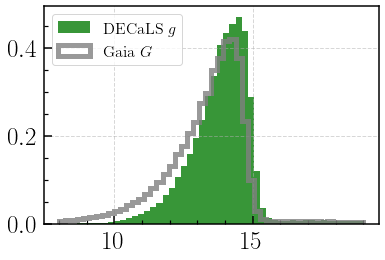

In [40]:
_ = plt.hist(dr8_psrc[(dr8_psrc['MASKBITS'] & 0x4) > 0]['MAG_G_DERED'], bins=50, range=(8, 19),
             label=r'${\rm DECaLS}\ g$', alpha=0.9, density=True, color='forestgreen')
_ = plt.hist(dr8_psrc[(dr8_psrc['MASKBITS'] & 0x4) > 0]['GAIA_PHOT_G_MEAN_MAG'], bins=50, range=(8, 19), 
             histtype='step', linewidth=5, alpha=0.8, label=r'${\rm Gaia}\ G$', density=True, edgecolor='gray')
plt.legend(fontsize=16)

Text(0.5, 0, '$\\rm Magnitude$')

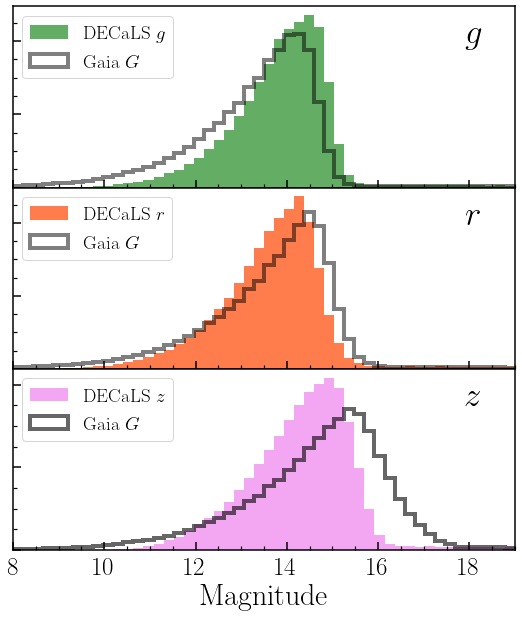

In [52]:
fig = plt.figure(figsize=(9, 10))
plt.subplots_adjust(wspace=0, hspace=0)

ax1 = plt.subplot(311)
#ax1.set_yscale('log')
ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=100)

_ = ax1.hist(dr8_psrc[(dr8_psrc['MASKBITS'] & 0x4) > 0]['MAG_G_DERED'], bins=50, range=(8, 19),
             label=r'${\rm DECaLS}\ g$', alpha=0.7, density=True, color='forestgreen')

_ = ax1.hist(dr8_psrc[(dr8_psrc['MASKBITS'] & 0x4) > 0]['GAIA_PHOT_G_MEAN_MAG'], bins=50, range=(8, 19), 
             histtype='step', linewidth=4, alpha=0.5, label=r'${\rm Gaia}\ G$', 
             density=True, edgecolor='k')

ax1.legend(loc='upper left', fontsize=19)
ax1.set_xlim(8, 19)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.text(0.9, 0.8, r'$g$', fontsize=35, transform=ax1.transAxes)

ax2 = plt.subplot(312)
#ax2.set_yscale('log')
ax2.grid(linestyle='--', linewidth=2, alpha=0.3)

_ = ax2.hist(dr8_psrc[(dr8_psrc['MASKBITS'] & 0x8) > 0]['MAG_R_DERED'], bins=50, range=(8, 19),
             label=r'${\rm DECaLS}\ r$', alpha=0.7, density=True, color='orangered')

_ = ax2.hist(dr8_psrc[(dr8_psrc['MASKBITS'] & 0x8) > 0]['GAIA_PHOT_G_MEAN_MAG'], bins=50, range=(8, 19), 
             histtype='step', linewidth=4, alpha=0.5, label=r'${\rm Gaia}\ G$', 
             density=True, edgecolor='k')

ax2.legend(loc='upper left', fontsize=19)
ax2.set_xlim(8, 19)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax2.text(0.9, 0.8, r'$r$', fontsize=35, transform=ax2.transAxes)

ax3 = plt.subplot(313)
#ax3.set_yscale('log')
ax3.grid(linestyle='--', linewidth=2, alpha=0.3)

_ = ax3.hist(dr8_psrc[(dr8_psrc['MASKBITS'] & 0x10) > 0]['MAG_Z_DERED'], bins=50, range=(8, 19),
             label=r'${\rm DECaLS}\ z$', alpha=0.7, density=True, color='violet')

_ = ax3.hist(dr8_psrc[(dr8_psrc['MASKBITS'] & 0x10) > 0]['GAIA_PHOT_G_MEAN_MAG'], bins=50, range=(8, 19), 
             histtype='step', linewidth=4, alpha=0.6, label=r'${\rm Gaia}\ G$', 
             density=True, edgecolor='k')

ax3.legend(loc='upper left', fontsize=19)
ax3.set_xlim(8, 19)
ax3.yaxis.set_ticklabels([])
ax3.text(0.9, 0.8, r'$z$', fontsize=35, transform=ax3.transAxes)

ax3.set_xlabel(r'$\rm Magnitude$', fontsize=30)

In [53]:
satu_g = dr8_psrc[(dr8_psrc['MASKBITS'] & 0x4) > 0]
satu_r = dr8_psrc[(dr8_psrc['MASKBITS'] & 0x8) > 0]
satu_z = dr8_psrc[(dr8_psrc['MASKBITS'] & 0x10) > 0]

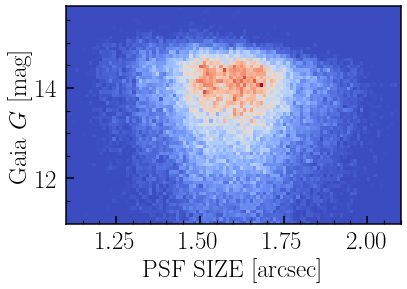

In [75]:
_ = plt.hist2d(satu_g['PSFSIZE_G'], satu_g['GAIA_PHOT_G_MEAN_MAG'], bins=(100, 60), 
               vmin=2, range=([1.1, 2.1], [11, 15.8]), cmap='coolwarm')

_ = plt.xlabel(r'$\rm PSF\ SIZE\ [arcsec]$', fontsize=25)
_ = plt.ylabel(r'${\rm Gaia}\ G\ [\rm mag]$', fontsize=25)

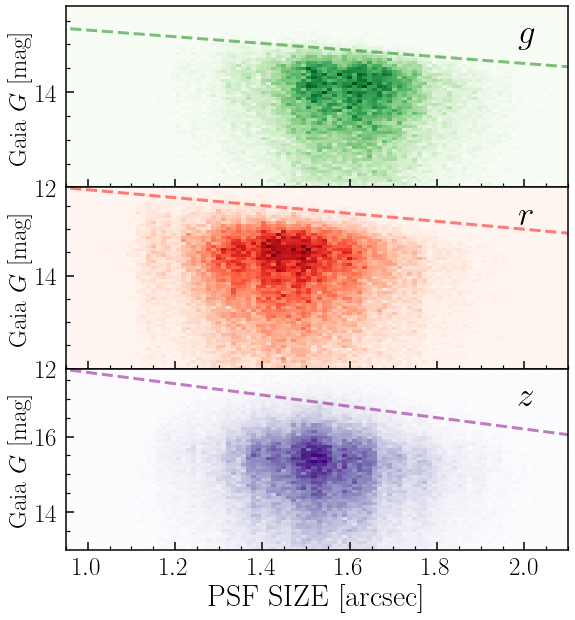

In [129]:
fig = plt.figure(figsize=(9, 10))
plt.subplots_adjust(wspace=0, hspace=0)

ax1 = plt.subplot(311)
ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=100)

_ = ax1.hist2d(satu_g['PSFSIZE_G'], satu_g['GAIA_PHOT_G_MEAN_MAG'], bins=(100, 60), 
               vmin=2, range=([0.95, 2.1], [12, 15.8]), cmap='Greens')

ax1.xaxis.set_ticklabels([])
ax1.text(0.9, 0.8, r'$g$', fontsize=35, transform=ax1.transAxes)
_ = ax1.set_ylabel(r'${\rm Gaia}\ G\ [\rm mag]$', fontsize=25)

ax2 = plt.subplot(312)
ax2.grid(linestyle='--', linewidth=2, alpha=0.3)

_ = ax2.hist2d(satu_r['PSFSIZE_R'], satu_r['GAIA_PHOT_G_MEAN_MAG'], bins=(100, 60), 
               vmin=2, range=([0.95, 2.1], [12, 15.9]), cmap='Reds')

ax2.xaxis.set_ticklabels([])
ax2.text(0.9, 0.8, r'$r$', fontsize=35, transform=ax2.transAxes)
_ = ax2.set_ylabel(r'${\rm Gaia}\ G\ [\rm mag]$', fontsize=25)

ax3 = plt.subplot(313)
ax3.grid(linestyle='--', linewidth=2, alpha=0.3)

_ = ax3.hist2d(satu_z['PSFSIZE_Z'], satu_z['GAIA_PHOT_G_MEAN_MAG'], bins=(100, 60), 
               vmin=2, range=([0.95, 2.1], [13, 17.8]), cmap='Purples')

ax3.text(0.9, 0.8, r'$z$', fontsize=35, transform=ax3.transAxes)
_ = ax3.set_ylabel(r'${\rm Gaia}\ G\ [\rm mag]$', fontsize=25)

_ = ax3.set_xlabel(r'$\rm PSF\ SIZE\ [arcsec]$', fontsize=30)

psf_arr = np.linspace(0.96, 2.15, 100)

ax1.plot(psf_arr, -0.70 * psf_arr + 16.0, linestyle='--', linewidth=3, alpha=0.5, c='g')
ax2.plot(psf_arr, -0.85 * psf_arr + 16.7, linestyle='--', linewidth=3, alpha=0.5, c='r')
ax3.plot(psf_arr, -1.50 * psf_arr + 19.2, linestyle='--', linewidth=3, alpha=0.5, c='purple')